In [2]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [4]:

# Cell 2: Load and inspect the dataset
file_path = 'datasets/cleaned/merged_fx_dataset.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Head:
        Date   Buying  Selling  MidRate   MPR  GhInflationRate  BrentOil  \
0 2024-12-31  14.6927  14.7074    14.70  27.0            23.82     73.18   
1 2024-12-30  14.7026  14.7174    14.71  27.0            23.82     73.18   
2 2024-12-27  14.6927  14.7074    14.70  27.0            23.82     73.18   
3 2024-12-24  14.6427  14.6573    14.65  27.0            23.82     73.18   
4 2024-12-23  14.6427  14.6573    14.65  27.0            23.82     73.18   

      Cocoa     Gold  GhInterestRate    GhGDP      USGDP  USInflationRate  \
0  10869.14  2641.45           27.03  53957.1  23542.349           123.98   
1  10869.14  2641.45           27.03  53957.1  23542.349           123.98   
2  10869.14  2641.45           27.03  53957.1  23542.349           123.98   
3  10869.14  2641.45           27.03  53957.1  23542.349           123.98   
4  10869.14  2641.45           27.03  53957.1  23542.349           123.98   

   USInterestRate  
0            4.33  
1            4.33  
2     

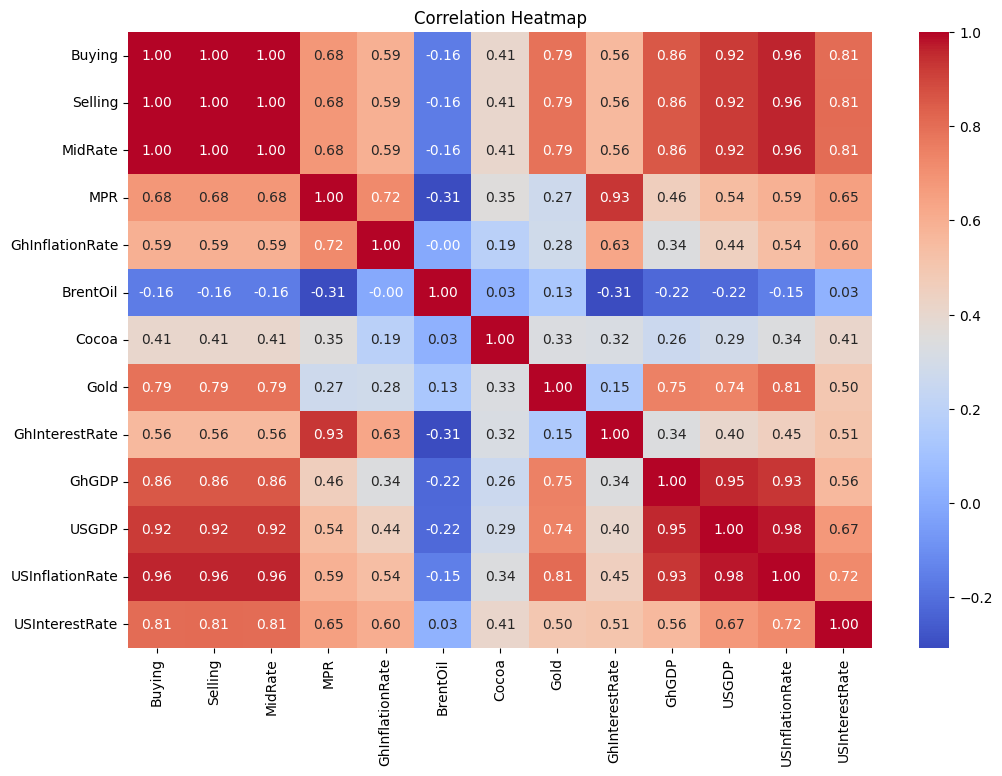

In [24]:
# Cell 3: Exploratory Data Analysis (EDA) - Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(data.drop(columns=['Date']).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [23]:
correlation_matrix = data.corr()
correlation_matrix['Buying'].sort_values(ascending=False)

Buying             1.000000
MidRate            0.999999
Selling            0.999995
USInflationRate    0.963458
USGDP              0.920332
Date               0.888256
GhGDP              0.856276
USInterestRate     0.805386
Gold               0.786830
MPR                0.682311
GhInflationRate    0.593068
GhInterestRate     0.557285
Cocoa              0.405011
BrentOil          -0.161347
Name: Buying, dtype: float64

In [25]:
data = data.drop(columns=['Selling', 'MidRate', 'MPR', 'GhGDP'])

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4217 entries, 4216 to 0
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             4217 non-null   datetime64[ns]
 1   Buying           4217 non-null   float64       
 2   GhInflationRate  4217 non-null   float64       
 3   BrentOil         4217 non-null   float64       
 4   Cocoa            4217 non-null   float64       
 5   Gold             4217 non-null   float64       
 6   GhInterestRate   4217 non-null   float64       
 7   USGDP            4217 non-null   float64       
 8   USInflationRate  4217 non-null   float64       
 9   USInterestRate   4217 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 362.4 KB


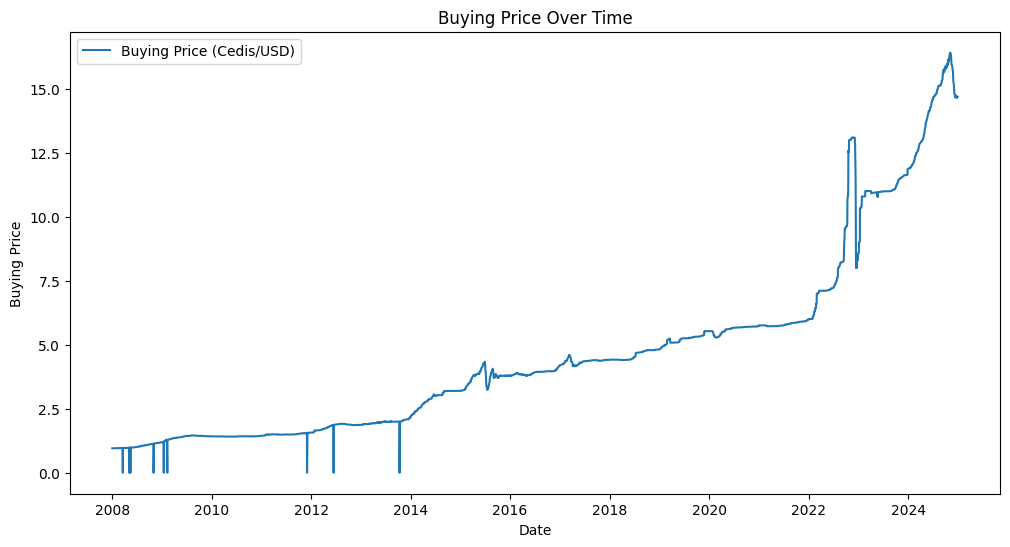

In [27]:
# Cell 4: Exploratory Data Analysis (EDA) - Time series visualization
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Buying'], label='Buying Price (Cedis/USD)')
plt.xlabel('Date')
plt.ylabel('Buying Price')
plt.title('Buying Price Over Time')
plt.legend()
plt.show()

In [28]:
# Cell 5: Data Preprocessing - Handle missing values
data = data.dropna()  # Drop rows with missing values
# Ensure 'date' is in datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')  # Sort by date

# Cell 6: Data Preprocessing - Feature scaling
# Exclude target and date
features = data.drop(columns=['Date', 'Buying'])
target = data['Buying']

In [30]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

In [47]:
# Cell 7: Create sequences for LSTM
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

In [61]:
# sequence_length = 30  # Use 30 days of data to predict the next day
sequence_length = 30
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

# Cell 8: Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (3349, 30, 8)
Validation set shape: (419, 30, 8)
Test set shape: (419, 30, 8)


In [62]:
# Cell 9: Build the LSTM model
# model = Sequential([
#     LSTM(64, return_sequences=True, input_shape=(
#         X_train.shape[1], X_train.shape[2])),
#     Dropout(0.2),
#     LSTM(32, return_sequences=False),
#     Dropout(0.2),
#     Dense(1)
# ])

# Enhance the model architecture
m = Sequential([
    LSTM(128, return_sequences=True, input_shape=(
        X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

m.compile(optimizer='adam', loss='mse', metrics=['mse'])
m.summary()

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 30, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,001 (515.63 KB)

 Trainable params: 132,001 (515.63 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Cell 10: Train the model
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

history = m.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.7491e-04 - mse: 9.7491e-04 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 8.6280e-04 - mse: 8.6280e-04 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 7.2468e-04 - mse: 7.2468e-04 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.9694e-04 - mse: 5.9694e-04 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4766e-04 - mse: 5.4766e-04 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.0998e-04 - mse: 5.0998e-04 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.2664e-04 - mse: 4.2664e-04 - val_loss: 0.0250 - val_mse

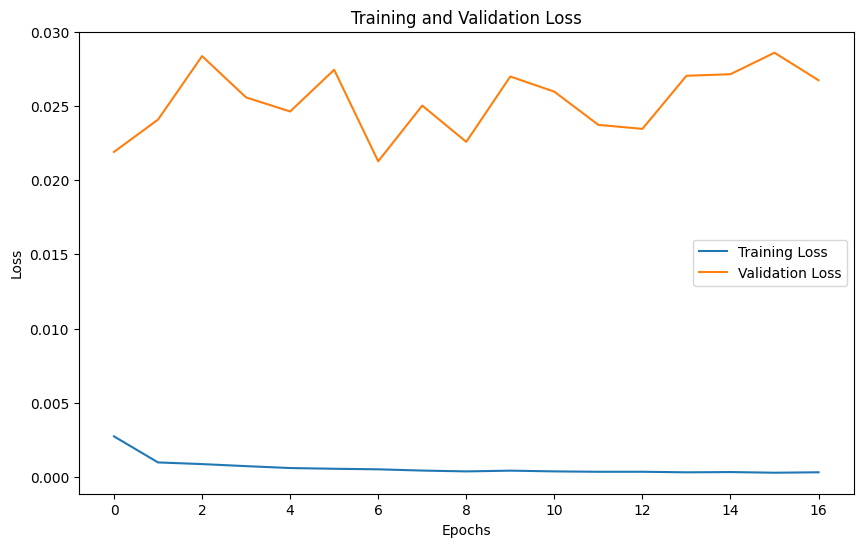

In [64]:
# Cell 11: Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [65]:
# Cell 12: Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test R2 Score: {r2}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test MSE: 25.028967947364897
Test RMSE: 5.0028959560803274
Test R2 Score: -6.41977055856258


In [18]:
test_dates = data['Date'][-len(y_test_rescaled):]

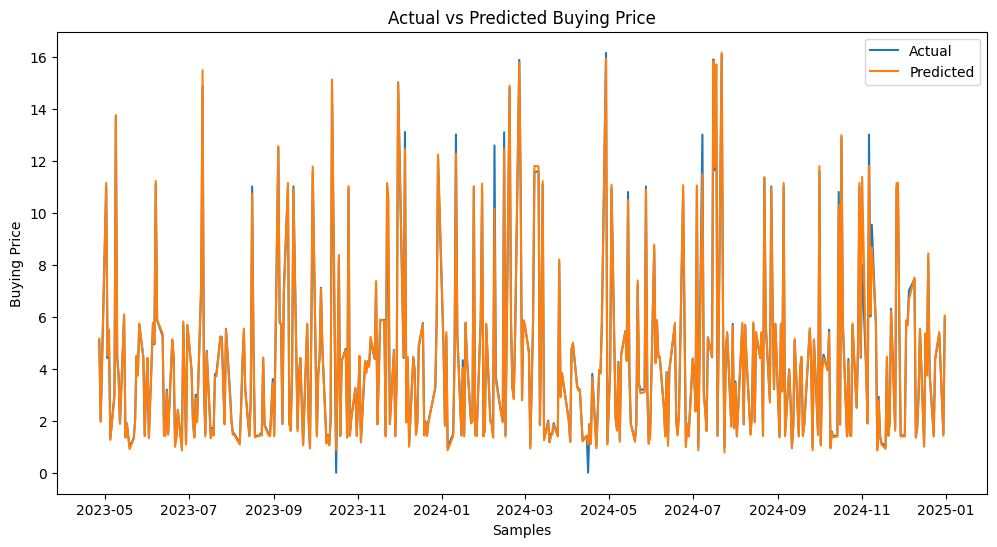

In [19]:
# Cell 13: Visualize predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_rescaled, label='Actual')
plt.plot(test_dates, y_pred_rescaled, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Buying Price')
plt.title('Actual vs Predicted Buying Price')
plt.legend()
plt.show()